In [1]:
import pandas as pd
sampled_data = pd.read_csv("added_race_bias.csv")

In [2]:
import numpy as np

def calculate_confusion_matrix(y_true, y_pred, group):
    # Ensure that group is a boolean array for indexing
    group = group.astype(bool)

    # Filter the predictions and true values based on the group
    y_true_group = y_true[group]
    y_pred_group = y_pred[group]

    # Calculate true positives, false positives, true negatives, and false negatives
    tp = np.sum((y_pred_group == 1) & (y_true_group == 1))
    tn = np.sum((y_pred_group == 0) & (y_true_group == 0))
    fp = np.sum((y_pred_group == 1) & (y_true_group == 0))
    fn = np.sum((y_pred_group == 0) & (y_true_group == 1))

    return tp, tn, fp, fn

def EqualOpportunityDifference(y, pred, group_a, group_b):
    tp_a, _, _, fn_a = calculate_confusion_matrix(y, pred, group_a)
    tp_b, _, _, fn_b = calculate_confusion_matrix(y, pred, group_b)
    tpr_a = tp_a / (tp_a + fn_a) if (tp_a + fn_a) > 0 else 0
    tpr_b = tp_b / (tp_b + fn_b) if (tp_b + fn_b) > 0 else 0
    return tpr_b - tpr_a

def FalsePositiveRateBalance(y, pred, group_a, group_b):
    _, tn_a, fp_a, _ = calculate_confusion_matrix(y, pred, group_a)
    _, tn_b, fp_b, _ = calculate_confusion_matrix(y, pred, group_b)
    fpr_a = fp_a / (fp_a + tn_a) if (fp_a + tn_a) > 0 else 0
    fpr_b = fp_b / (fp_b + tn_b) if (fp_b + tn_b) > 0 else 0
    return fpr_b - fpr_a

def EqualisedOdds(y, pred, group_a, group_b):
    return (EqualOpportunityDifference(y, pred, group_a, group_b) +
            FalsePositiveRateBalance(y, pred, group_a, group_b)) / 2

def PredictiveParityDifference(y, pred, group_a, group_b):
    tp_a, _, fp_a, _ = calculate_confusion_matrix(y, pred, group_a)
    tp_b, _, fp_b, _ = calculate_confusion_matrix(y, pred, group_b)
    precision_a = tp_a / (tp_a + fp_a) if (tp_a + fp_a) > 0 else 0
    precision_b = tp_b / (tp_b + fp_b) if (tp_b + fp_b) > 0 else 0
    return precision_b - precision_a

def StatisticalParityDifference(y, pred, group_a, group_b):
    # Ensure the correct counts within each group
    positive_count_a = np.sum(pred[group_a == 1])
    positive_count_b = np.sum(pred[group_b == 1])

    # Ensure the total counts represent the size of each group
    total_count_a = np.sum(group_a)
    total_count_b = np.sum(group_b)

    # Calculate the positive rates for each group
    positive_rate_a = positive_count_a / total_count_a if total_count_a > 0 else 0
    positive_rate_b = positive_count_b / total_count_b if total_count_b > 0 else 0

    # Debugging prints
    print("Group A positive count:", positive_count_a, "Total A:", total_count_a, "Rate A:", positive_rate_a)
    print("Group B positive count:", positive_count_b, "Total B:", total_count_b, "Rate B:", positive_rate_b)

    # Return the difference in positive rates between the two groups
    return positive_rate_b - positive_rate_a



In [3]:
value_counts = sampled_data['derived_race'].value_counts()
print(value_counts)

2.0    244511
0.0     23032
1.0     18221
Name: derived_race, dtype: int64


In [4]:
# 2.0 = white
# 1.0 = black
# 0.0 = asian
group_a = (sampled_data['derived_race'] == 2.0).astype(int)
group_b = (sampled_data['derived_race'] != 2.0).astype(int)
group_c = (sampled_data['derived_race'] != 1.0).astype(int)
group_d = (sampled_data['derived_race'] == 1.0).astype(int)
group_g = (sampled_data['derived_race'] == 0.0).astype(int)
group_h = (sampled_data['derived_race'] == 1.0).astype(int)
group_i = (sampled_data['derived_race'] == 2.0).astype(int)
group_j = (sampled_data['derived_race'] == 0.0).astype(int)

bias_metrics = {
    "Equal Opportunity Difference": EqualOpportunityDifference,
    "False Positive Rate Balance": FalsePositiveRateBalance,
    "Equalised Odds": EqualisedOdds,
    "Predictive Parity Difference": PredictiveParityDifference,
    "Statistical Parity Difference": StatisticalParityDifference
}

from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, precision_score, roc_auc_score

# setup the metrics to be computed
from sklearn import metrics
perf_metrics = {"Accuracy": metrics.accuracy_score, 
                "Precision": metrics.precision_score, 
                "Recall": metrics.recall_score,
                "AUC": metrics.roc_auc_score, 
                "F1-Score": metrics.f1_score,
                "Confusion Matrix": metrics.confusion_matrix
                }
                


In [5]:
from sklearn.model_selection import train_test_split

# Assuming sampled_data is your DataFrame
y = sampled_data['action_taken']

# Exclude both 'action_taken' and 'applicant_race_1' from the features
X = sampled_data.drop(['action_taken', 'derived_race','derived_sex'], axis=1)

test_set = 0.2
seed = 123

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set, random_state=seed, stratify=y)


In [6]:
X_train.columns

Index(['aus_1', 'applicant_credit_score_type', 'balloon_payment',
       'business_or_commercial_purpose', 'co_applicant_credit_score_type',
       'combined_loan_to_value_ratio', 'debt_to_income_ratio',
       'derived_dwelling_category', 'ffiec_msa_md_median_family_income',
       'hoepa_status', 'income', 'initially_payable_to_institution',
       'interest_only_payment', 'loan_amount', 'loan_purpose',
       'negative_amortization', 'occupancy_type', 'preapproval',
       'property_value', 'purchaser_type', 'total_units',
       'open_end_line_of_credit', 'tract_owner_occupied_units',
       'derived_msa_md', 'tract_median_age_of_housing_units',
       'tract_minority_population_percent', 'tract_one_to_four_family_homes',
       'tract_population', 'tract_to_msa_income_percentage'],
      dtype='object')

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import pandas as pd

lr = LogisticRegression(random_state=10, solver="lbfgs", penalty="none", max_iter=2000)
mv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

white_metrics_all = pd.DataFrame()
black_metrics_all = pd.DataFrame()
asianblack_metrics_all = pd.DataFrame()
asianwhite_metrics_all = pd.DataFrame()
k, i = True, 1
i = 1
for (train, test) in mv.split(X, y):
    lr.fit(X.iloc[train], y.iloc[train].values.ravel())
    ypred_prob = lr.predict_proba(X.iloc[test]).ravel()[1::2] # get probabilities
    ypred_class = lr.predict(X.iloc[test])

    # compute performance metrics
    metrics = []
    for pf in perf_metrics.keys():
        if pf == "AUC":
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_prob)]]
        else:
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_class)]]

    # concatenate results
    df_m = pd.DataFrame(metrics, columns=["Metric", "Value"])
    df_m["Fold"] = i
    i += 1
    if k:
        df_metrics = df_m.copy()
        k=0
    else:
        df_metrics = pd.concat([df_metrics, df_m.copy()], axis=0, ignore_index=True)

    # Reset these lists inside the loop for each fold
    white_metrics = []
    black_metrics = []
    asianblack_metrics = []
    asianwhite_metrics = []

    for bias in bias_metrics.keys():
        white_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_a[test], group_b[test])])
        black_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_c[test], group_d[test])])                                    
        asianblack_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_g[test], group_h[test])])
        asianwhite_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_i[test], group_j[test])])

        # Convert lists to DataFrames before concatenation
        white_df = pd.DataFrame(white_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        black_df = pd.DataFrame(black_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        asianwhite_df = pd.DataFrame(asianwhite_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        asianblack_df = pd.DataFrame(asianblack_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        

    # Concatenate the new DataFrames with the all metrics DataFrames
    white_metrics_all = pd.concat([white_metrics_all, white_df], axis=0)
    black_metrics_all = pd.concat([black_metrics_all, black_df], axis=0)
    asianblack_metrics_all = pd.concat([asianblack_metrics_all, asianblack_df], axis=0)
    asianwhite_metrics_all = pd.concat([asianwhite_metrics_all, asianwhite_df], axis=0)
    
    i += 1

white_summary = white_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
black_summary = black_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
asianblack_summary = asianblack_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
asianwhite_summary = asianwhite_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])


Group A positive count: 43891.0 Total A: 48935 Rate A: 0.896924491672627
Group B positive count: 6873.0 Total B: 8218 Rate B: 0.8363348746653687
Group A positive count: 47842.0 Total A: 53447 Rate A: 0.8951297547102738
Group B positive count: 2922.0 Total B: 3706 Rate B: 0.788451160280626
Group A positive count: 3951.0 Total A: 4512 Rate A: 0.8756648936170213
Group B positive count: 2922.0 Total B: 3706 Rate B: 0.788451160280626
Group A positive count: 43891.0 Total A: 48935 Rate A: 0.896924491672627
Group B positive count: 3951.0 Total B: 4512 Rate B: 0.8756648936170213
Group A positive count: 43937.0 Total A: 48902 Rate A: 0.8984704102081714
Group B positive count: 6901.0 Total B: 8251 Rate B: 0.8363834686704642
Group A positive count: 48003.0 Total A: 53559 Rate A: 0.89626393323251
Group B positive count: 2835.0 Total B: 3594 Rate B: 0.7888146911519198
Group A positive count: 4066.0 Total A: 4657 Rate A: 0.8730942666952974
Group B positive count: 2835.0 Total B: 3594 Rate B: 0.78881

In [8]:
# If 'Value' is not a numeric type, you may need to convert it
if not pd.api.types.is_numeric_dtype(df_metrics['Value']):
    df_metrics['Value'] = pd.to_numeric(df_metrics['Value'], errors='coerce')

# Now try creating the pivot table again
pivot_table = df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])
df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])


,mean,std
,Value,Value
Metric,,
AUC,0.946555,0.000717
Accuracy,0.951698,0.001125
F1-Score,0.972798,0.000637
Precision,0.972751,0.000739
Recall,0.972846,0.000963


<Axes: title={'center': 'Value'}, xlabel='Metric'>

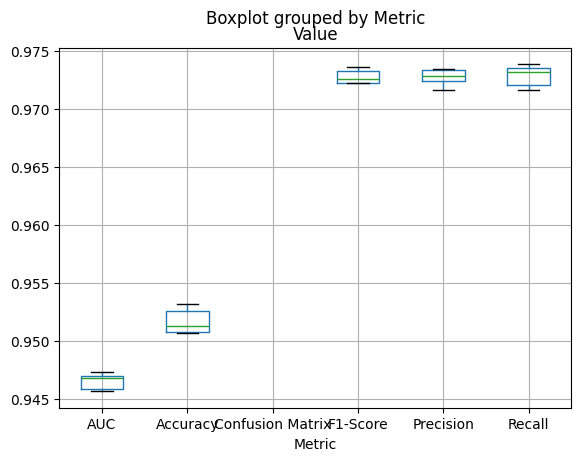

In [9]:
df_metrics.boxplot(column='Value', by='Metric')

In [10]:
print("WHITE/NOT WHITE:")
white_summary

WHITE/NOT WHITE:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,-0.029077,0.004281
Equalised Odds,0.123228,0.007650
False Positive Rate Balance,0.275533,0.014722
Predictive Parity Difference,-0.091106,0.002882
Statistical Parity Difference,-0.062578,0.002972


In [11]:
print("\nBLACK/NOT BLACK:")
black_summary


BLACK/NOT BLACK:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,-0.006277,0.004967
Equalised Odds,0.162035,0.006545
False Positive Rate Balance,0.330348,0.012510
Predictive Parity Difference,-0.210649,0.004255
Statistical Parity Difference,-0.110830,0.004614


In [12]:
print("\nASIAN/WHITE:")
asianwhite_summary


ASIAN/WHITE:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,-0.039582,0.004439
Equalised Odds,0.014882,0.015038
False Positive Rate Balance,0.069347,0.030238
Predictive Parity Difference,-0.005898,0.003743
Statistical Parity Difference,-0.022847,0.002845


In [13]:
print("\ASIAN/BLACK:")
asianblack_summary

\ASIAN/BLACK:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,0.029863,0.004622
Equalised Odds,0.148186,0.012573
False Positive Rate Balance,0.266509,0.029389
Predictive Parity Difference,-0.205249,0.005886
Statistical Parity Difference,-0.089948,0.004430


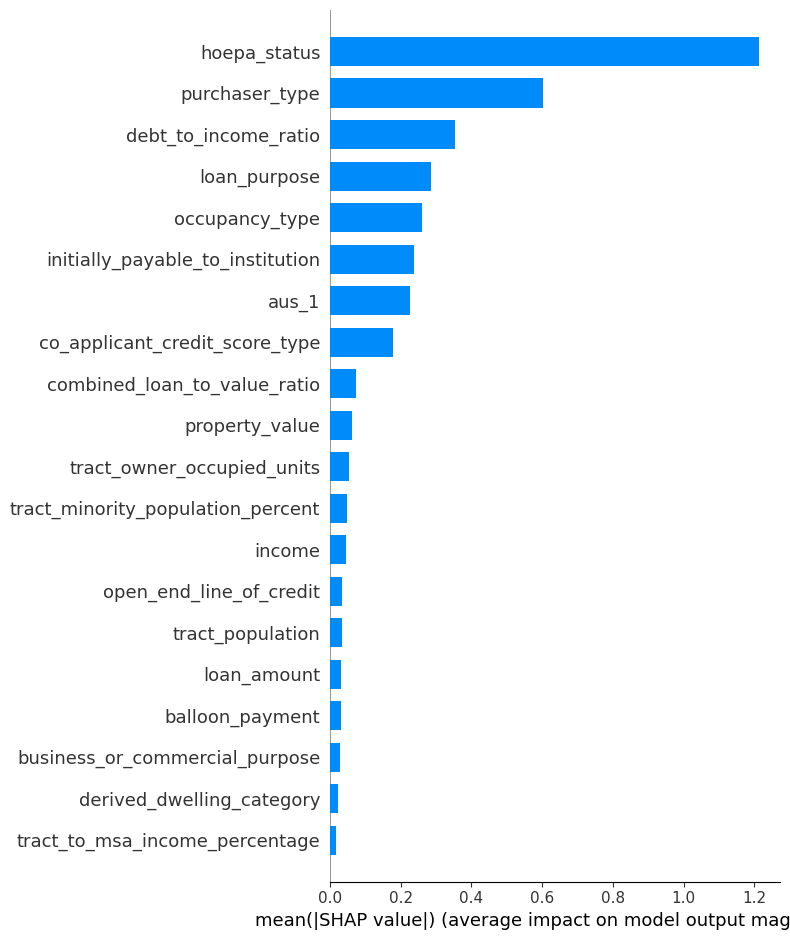

In [14]:
import shap
explainer = shap.LinearExplainer(lr, X_train)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")



In [15]:
from xgboost import XGBClassifier
# Initialize the XGBClassifier
xgb_clf = XGBClassifier(use_label_encoder=False)

mv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

import pandas as pd
k, i = True, 1

for (train, test) in mv.split(X, y):
    # fit model
    xgb_clf = xgb_clf.fit(X.iloc[train], y.iloc[train].values.ravel())
    
    # get predictions in the test set
    ypred_prob = xgb_clf.predict_proba(X.iloc[test]).ravel()[1::2] # get probabilities
    ypred_class = xgb_clf.predict(X.iloc[test])
    # compute performance metrics
    metrics = []
    for pf in perf_metrics.keys():
        if pf in ["AUC"]:
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_prob)]]
        else:
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_class)]]

    # concatenate results
    df_m = pd.DataFrame(metrics, columns=["Metric", "Value"])
    df_m["Fold"] = i
    i += 1
    if k:
        df_metrics = df_m.copy()
        k=0
    else:
        df_metrics = pd.concat([df_metrics, df_m.copy()], axis=0, ignore_index=True)

    # compute performance metrics
    white_metrics = []
    black_metrics = []
    for bias in bias_metrics.keys():
        white_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_a[test], group_b[test])])
        black_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_c[test], group_d[test])])                                    
        asianblack_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_g[test], group_h[test])])
        asianwhite_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_i[test], group_j[test])])

        # Convert lists to DataFrames before concatenation
        white_df = pd.DataFrame(white_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        black_df = pd.DataFrame(black_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        asianwhite_df = pd.DataFrame(asianwhite_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        asianblack_df = pd.DataFrame(asianblack_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        

    # Concatenate the new DataFrames with the all metrics DataFrames
    white_metrics_all = pd.concat([white_metrics_all, white_df], axis=0)
    black_metrics_all = pd.concat([black_metrics_all, black_df], axis=0)
    asianblack_metrics_all = pd.concat([asianblack_metrics_all, asianblack_df], axis=0)
    asianwhite_metrics_all = pd.concat([asianwhite_metrics_all, asianwhite_df], axis=0)
    
    i += 1

white_summary = white_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
black_summary = black_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
asianblack_summary = asianblack_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
asianwhite_summary = asianwhite_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])

Group A positive count: 44317 Total A: 48935 Rate A: 0.9056299172371514
Group B positive count: 7016 Total B: 8218 Rate B: 0.8537357021173034
Group A positive count: 48391 Total A: 53447 Rate A: 0.9054016128126929
Group B positive count: 2942 Total B: 3706 Rate B: 0.7938478143550999
Group A positive count: 4074 Total A: 4512 Rate A: 0.9029255319148937
Group B positive count: 2942 Total B: 3706 Rate B: 0.7938478143550999
Group A positive count: 44317 Total A: 48935 Rate A: 0.9056299172371514
Group B positive count: 4074 Total B: 4512 Rate B: 0.9029255319148937
Group A positive count: 44235 Total A: 48902 Rate A: 0.90456423050182
Group B positive count: 7068 Total B: 8251 Rate B: 0.8566234395830808
Group A positive count: 48433 Total A: 53559 Rate A: 0.9042924625179708
Group B positive count: 2870 Total B: 3594 Rate B: 0.798553144129104
Group A positive count: 4198 Total A: 4657 Rate A: 0.9014386944384797
Group B positive count: 2870 Total B: 3594 Rate B: 0.798553144129104
Group A positi

In [16]:
# If 'Value' is not a numeric type, you may need to convert it
if not pd.api.types.is_numeric_dtype(df_metrics['Value']):
    df_metrics['Value'] = pd.to_numeric(df_metrics['Value'], errors='coerce')

# Now try creating the pivot table again
pivot_table = df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])
df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])


,mean,std
,Value,Value
Metric,,
AUC,0.957620,0.001111
Accuracy,0.959432,0.000964
F1-Score,0.977272,0.000538
Precision,0.972200,0.000753
Recall,0.982397,0.000662


<Axes: title={'center': 'Value'}, xlabel='Metric'>

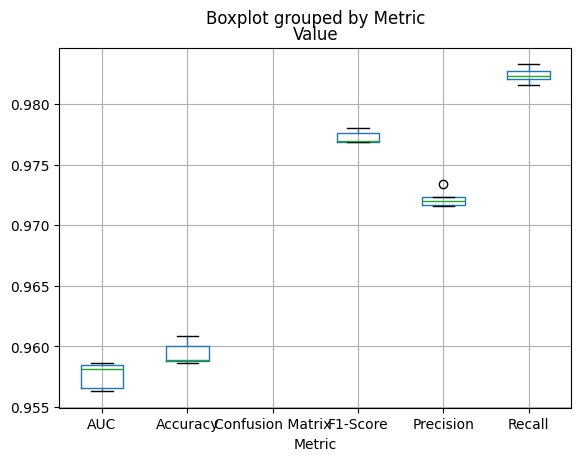

In [17]:
df_metrics.boxplot(column='Value', by='Metric')

In [18]:
print("WHITE/NOT WHITE:")
white_summary

WHITE/NOT WHITE:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,-0.019977,0.010071
Equalised Odds,0.126629,0.007423
False Positive Rate Balance,0.273236,0.012850
Predictive Parity Difference,-0.089884,0.002849
Statistical Parity Difference,-0.055855,0.007610


In [19]:
print("\nBLACK/NOT BLACK:")
black_summary


BLACK/NOT BLACK:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,-0.006049,0.003589
Equalised Odds,0.162818,0.005188
False Positive Rate Balance,0.331685,0.009981
Predictive Parity Difference,-0.211107,0.003494
Statistical Parity Difference,-0.110670,0.003607


In [20]:
print("\nASIAN/WHITE:")
asianwhite_summary


ASIAN/WHITE:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,-0.023621,0.015058
Equalised Odds,0.017736,0.010505
False Positive Rate Balance,0.059092,0.024269
Predictive Parity Difference,-0.004582,0.003007
Statistical Parity Difference,-0.009387,0.011142


In [21]:
print("\ASIAN/BLACK:")
asianblack_summary

\ASIAN/BLACK:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,0.015523,0.014174
Equalised Odds,0.146067,0.008025
False Positive Rate Balance,0.276611,0.023053
Predictive Parity Difference,-0.206889,0.003986
Statistical Parity Difference,-0.102629,0.009303


100%|===================| 228530/228611 [11:02<00:00]       

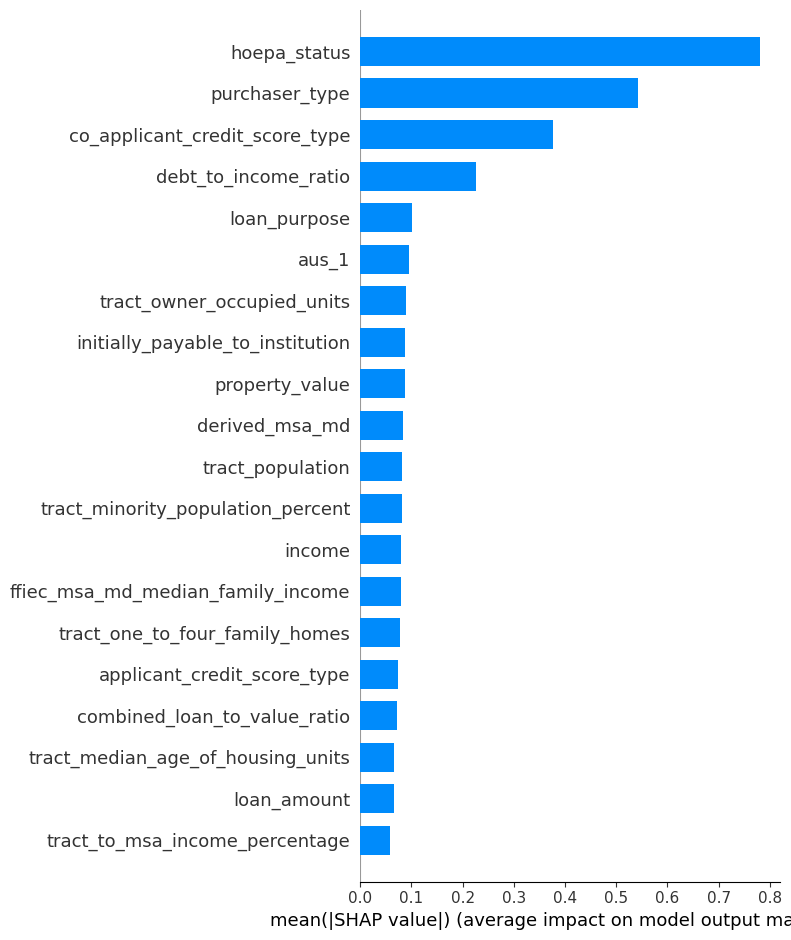

In [22]:

explainer = shap.TreeExplainer(xgb_clf, X_train)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")



In [23]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

mv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

import pandas as pd
k, i = True, 1

for (train, test) in mv.split(X, y):
    # fit model
    random_forest = random_forest.fit(X.iloc[train], y.iloc[train].values.ravel())
    
    # get predictions in the test set
    ypred_prob = random_forest.predict_proba(X.iloc[test]).ravel()[1::2] # get probabilities
    ypred_class = random_forest.predict(X.iloc[test])
    # compute performance metrics
    metrics = []
    for pf in perf_metrics.keys():
        if pf in ["AUC", "Brier"]:
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_prob)]]
        else:
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_class)]]

    # concatenate results
    df_m = pd.DataFrame(metrics, columns=["Metric", "Value"])
    df_m["Fold"] = i
    i += 1
    if k:
        df_metrics = df_m.copy()
        k=0
    else:
        df_metrics = pd.concat([df_metrics, df_m.copy()], axis=0, ignore_index=True)

    # compute performance metrics
    white_metrics = []
    black_metrics = []
    for bias in bias_metrics.keys():
        white_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_a[test], group_b[test])])
        black_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_c[test], group_d[test])])                                    
        asianblack_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_g[test], group_h[test])])
        asianwhite_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_i[test], group_j[test])])

        # Convert lists to DataFrames before concatenation
        white_df = pd.DataFrame(white_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        black_df = pd.DataFrame(black_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        asianwhite_df = pd.DataFrame(asianwhite_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        asianblack_df = pd.DataFrame(asianblack_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        

    # Concatenate the new DataFrames with the all metrics DataFrames
    white_metrics_all = pd.concat([white_metrics_all, white_df], axis=0)
    black_metrics_all = pd.concat([black_metrics_all, black_df], axis=0)
    asianblack_metrics_all = pd.concat([asianblack_metrics_all, asianblack_df], axis=0)
    asianwhite_metrics_all = pd.concat([asianwhite_metrics_all, asianwhite_df], axis=0)
    
    i += 1

white_summary = white_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
black_summary = black_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
asianblack_summary = asianblack_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
asianwhite_summary = asianwhite_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])

Group A positive count: 44258.0 Total A: 48935 Rate A: 0.904424236231736
Group B positive count: 7011.0 Total B: 8218 Rate B: 0.853127281577026
Group A positive count: 48321.0 Total A: 53447 Rate A: 0.9040919041293244
Group B positive count: 2948.0 Total B: 3706 Rate B: 0.795466810577442
Group A positive count: 4063.0 Total A: 4512 Rate A: 0.9004875886524822
Group B positive count: 2948.0 Total B: 3706 Rate B: 0.795466810577442
Group A positive count: 44258.0 Total A: 48935 Rate A: 0.904424236231736
Group B positive count: 4063.0 Total B: 4512 Rate B: 0.9004875886524822
Group A positive count: 44163.0 Total A: 48902 Rate A: 0.9030918980818781
Group B positive count: 7071.0 Total B: 8251 Rate B: 0.8569870318749242
Group A positive count: 48376.0 Total A: 53559 Rate A: 0.9032282156126888
Group B positive count: 2858.0 Total B: 3594 Rate B: 0.7952142459654981
Group A positive count: 4213.0 Total A: 4657 Rate A: 0.9046596521365686
Group B positive count: 2858.0 Total B: 3594 Rate B: 0.7952

In [24]:
# If 'Value' is not a numeric type, you may need to convert it
if not pd.api.types.is_numeric_dtype(df_metrics['Value']):
    df_metrics['Value'] = pd.to_numeric(df_metrics['Value'], errors='coerce')

# Now try creating the pivot table again
pivot_table = df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])
df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])


,mean,std
,Value,Value
Metric,,
AUC,0.953151,0.000812
Accuracy,0.959960,0.000844
F1-Score,0.977552,0.000475
Precision,0.973164,0.000616
Recall,0.981979,0.000739


<Axes: title={'center': 'Value'}, xlabel='Metric'>

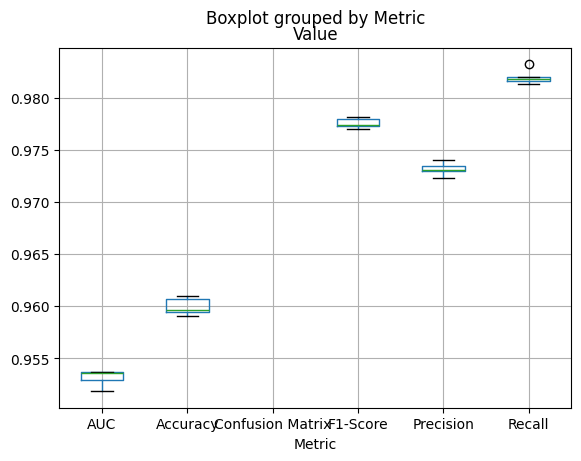

In [25]:
df_metrics.boxplot(column='Value', by='Metric')

In [26]:
print("WHITE/NOT WHITE:")
white_summary

WHITE/NOT WHITE:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,-0.016562,0.009550
Equalised Odds,0.128399,0.007024
False Positive Rate Balance,0.273361,0.011415
Predictive Parity Difference,-0.089308,0.002982
Statistical Parity Difference,-0.053441,0.007201


In [27]:
print("\nBLACK/NOT BLACK:")
black_summary


BLACK/NOT BLACK:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,-0.005858,0.003346
Equalised Odds,0.163266,0.004691
False Positive Rate Balance,0.332390,0.009291
Predictive Parity Difference,-0.210643,0.003313
Statistical Parity Difference,-0.111166,0.003534


In [28]:
print("\nASIAN/WHITE:")
asianwhite_summary


ASIAN/WHITE:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,-0.018470,0.012659
Equalised Odds,0.018481,0.011433
False Positive Rate Balance,0.055432,0.024363
Predictive Parity Difference,-0.004128,0.003137
Statistical Parity Difference,-0.004902,0.009677


In [29]:
print("\ASIAN/BLACK:")
asianblack_summary

\ASIAN/BLACK:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,0.010980,0.011988
Equalised Odds,0.146230,0.009422
False Positive Rate Balance,0.281480,0.023195
Predictive Parity Difference,-0.207279,0.003879
Statistical Parity Difference,-0.106703,0.008370


In [ ]:

explainer = shap.TreeExplainer(random_forest, X_train)
shap_values = explainer.shap_values(X_train,check_additivity=False)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [30]:
# from sklearn.svm import SVC

# # Create an SVM classifier
# svm = SVC(random_state=42)

# mv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

import pandas as pd
k, i = True, 1

from sklearn import svm

svm = svm.SVC(random_state=10, probability=True)

for (train, test) in mv.split(X, y):
    svm = svm.fit(X.iloc[train], y.iloc[train].values.ravel())
    
    ypred_prob = svm.predict_proba(X.iloc[test]).ravel()[1::2] # get probabilities
    ypred_class = svm.predict(X.iloc[test])
    # compute performance metrics
    metrics = []
    for pf in perf_metrics.keys():
        if pf == "AUC":
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_prob)]]
        else:
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_class)]]

    # concatenate results
    df_m = pd.DataFrame(metrics, columns=["Metric", "Value"])
    df_m["Fold"] = i
    i += 1
    if k:
        df_metrics = df_m.copy()
        k=0
    else:
        df_metrics = pd.concat([df_metrics, df_m.copy()], axis=0, ignore_index=True)

    white_metrics = []
    black_metrics = []
    for bias in bias_metrics.keys():
        white_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_a[test], group_b[test])])
        black_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_c[test], group_d[test])])                                    
        asianblack_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_g[test], group_h[test])])
        asianwhite_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_i[test], group_j[test])])

        # Convert lists to DataFrames before concatenation
        white_df = pd.DataFrame(white_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        black_df = pd.DataFrame(black_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        asianwhite_df = pd.DataFrame(asianwhite_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        asianblack_df = pd.DataFrame(asianblack_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        

    # Concatenate the new DataFrames with the all metrics DataFrames
    white_metrics_all = pd.concat([white_metrics_all, white_df], axis=0)
    black_metrics_all = pd.concat([black_metrics_all, black_df], axis=0)
    asianblack_metrics_all = pd.concat([asianblack_metrics_all, asianblack_df], axis=0)
    asianwhite_metrics_all = pd.concat([asianwhite_metrics_all, asianwhite_df], axis=0)
    
    i += 1

white_summary = white_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
black_summary = black_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
asianblack_summary = asianblack_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
asianwhite_summary = asianwhite_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])

Group A positive count: 44003.0 Total A: 48935 Rate A: 0.8992132420557883
Group B positive count: 6981.0 Total B: 8218 Rate B: 0.8494767583353614
Group A positive count: 48055.0 Total A: 53447 Rate A: 0.8991150111325238
Group B positive count: 2929.0 Total B: 3706 Rate B: 0.7903399892066919
Group A positive count: 4052.0 Total A: 4512 Rate A: 0.8980496453900709
Group B positive count: 2929.0 Total B: 3706 Rate B: 0.7903399892066919
Group A positive count: 44003.0 Total A: 48935 Rate A: 0.8992132420557883
Group B positive count: 4052.0 Total B: 4512 Rate B: 0.8980496453900709
Group A positive count: 43877.0 Total A: 48902 Rate A: 0.8972434665248865
Group B positive count: 7030.0 Total B: 8251 Rate B: 0.852017937219731
Group A positive count: 48062.0 Total A: 53559 Rate A: 0.8973655221344685
Group B positive count: 2845.0 Total B: 3594 Rate B: 0.7915971062882582
Group A positive count: 4185.0 Total A: 4657 Rate A: 0.8986471977668027
Group B positive count: 2845.0 Total B: 3594 Rate B: 0.

In [31]:
# If 'Value' is not a numeric type, you may need to convert it
if not pd.api.types.is_numeric_dtype(df_metrics['Value']):
    df_metrics['Value'] = pd.to_numeric(df_metrics['Value'], errors='coerce')

# Now try creating the pivot table again
pivot_table = df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])
df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])


,mean,std
,Value,Value
Metric,,
AUC,0.946011,0.001501
Accuracy,0.954889,0.000616
F1-Score,0.974637,0.000351
Precision,0.973004,0.000400
Recall,0.976275,0.000654


<Axes: title={'center': 'Value'}, xlabel='Metric'>

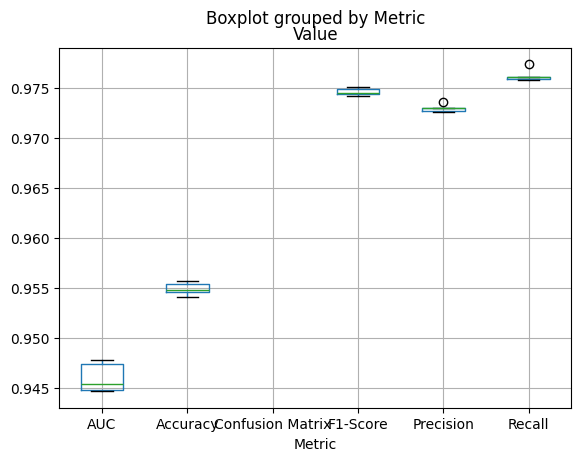

In [32]:
df_metrics.boxplot(column='Value', by='Metric')

In [33]:
print("WHITE/NOT WHITE:")
white_summary

WHITE/NOT WHITE:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,-0.014983,0.008793
Equalised Odds,0.129371,0.006769
False Positive Rate Balance,0.273726,0.010869
Predictive Parity Difference,-0.089204,0.002804
Statistical Parity Difference,-0.052116,0.006732


In [34]:
print("\nBLACK/NOT BLACK:")
black_summary


BLACK/NOT BLACK:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,-0.006151,0.003615
Equalised Odds,0.163074,0.004838
False Positive Rate Balance,0.332298,0.008719
Predictive Parity Difference,-0.210581,0.003117
Statistical Parity Difference,-0.111400,0.003848


In [35]:
print("\nASIAN/WHITE:")
asianwhite_summary


ASIAN/WHITE:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,-0.016253,0.011004
Equalised Odds,0.019478,0.011833
False Positive Rate Balance,0.055210,0.024082
Predictive Parity Difference,-0.004067,0.003153
Statistical Parity Difference,-0.002840,0.008625


In [36]:
print("\ASIAN/BLACK:")
asianblack_summary

\ASIAN/BLACK:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,0.009041,0.010542
Equalised Odds,0.145408,0.009869
False Positive Rate Balance,0.281775,0.022531
Predictive Parity Difference,-0.207059,0.003814
Statistical Parity Difference,-0.108735,0.007940


In [ ]:

explainer = shap.LinearExplainer(svm, X_train)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")



In [ ]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import StratifiedKFold

parameters = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

mv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

import pandas as pd
k, i = True, 1

for (train, test) in mv.split(X, y):
    train_data = lgb.Dataset(X.iloc[train],label=y.iloc[train])
    valid_data = lgb.Dataset(X.iloc[test],label=y.iloc[test], reference=train_data)

    lgb_model = lgb.train(parameters, train_data, valid_sets=[valid_data],num_boost_round=5000)

    # get predictions in the test set
    ypred_prob = lgb_model.predict(X.iloc[test]) # get probabilities
    ypred_class = (ypred_prob >= 0.5).astype(int)
    # compute performance metrics
    metrics = []
    for pf in perf_metrics.keys():
        if pf == "AUC":
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_prob)]]
        else:
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_class)]]

    # concatenate results
    df_m = pd.DataFrame(metrics, columns=["Metric", "Value"])
    df_m["Fold"] = i
    i += 1
    if k:
        df_metrics = df_m.copy()
        k=0
    else:
        df_metrics = pd.concat([df_metrics, df_m.copy()], axis=0, ignore_index=True)

    # compute performance metrics
    white_metrics = []
    black_metrics = []
    for bias in bias_metrics.keys():
        white_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_a[test], group_b[test])])
        black_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_c[test], group_d[test])])                                    
        asianblack_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_g[test], group_h[test])])
        asianwhite_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_i[test], group_j[test])])

        # Convert lists to DataFrames before concatenation
        white_df = pd.DataFrame(white_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        black_df = pd.DataFrame(black_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        asianwhite_df = pd.DataFrame(asianwhite_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        asianblack_df = pd.DataFrame(asianblack_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        

    # Concatenate the new DataFrames with the all metrics DataFrames
    white_metrics_all = pd.concat([white_metrics_all, white_df], axis=0)
    black_metrics_all = pd.concat([black_metrics_all, black_df], axis=0)
    asianblack_metrics_all = pd.concat([asianblack_metrics_all, asianblack_df], axis=0)
    asianwhite_metrics_all = pd.concat([asianwhite_metrics_all, asianwhite_df], axis=0)
    
    i += 1

white_summary = white_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
black_summary = black_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
asianblack_summary = asianblack_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
asianwhite_summary = asianwhite_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])

In [37]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import pandas as pd

# Initialize the sum of confusion matrices
sum_cm = np.zeros((2, 2))  # Adjust the size if your classification is not binary

parameters = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

mv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

k, i = True, 1
for (train, test) in mv.split(X, y):
    train_data = lgb.Dataset(X.iloc[train], label=y.iloc[train])
    valid_data = lgb.Dataset(X.iloc[test], label=y.iloc[test], reference=train_data)

    lgb_model = lgb.train(parameters, train_data, valid_sets=[valid_data], num_boost_round=5000)

    ypred_prob = lgb_model.predict(X.iloc[test])
    ypred_class = (ypred_prob >= 0.5).astype(int)

    # Calculate the confusion matrix for this fold and add to the sum
    cm = confusion_matrix(y.iloc[test], ypred_class)
    sum_cm += cm

    # Compute performance metrics
    metrics = []
    for pf in perf_metrics.keys():
        if pf == "AUC":
            metrics += [[pf, perf_metrics[pf](y.iloc[test], ypred_prob)]]
        elif pf != "Confusion Matrix":
            metrics += [[pf, perf_metrics[pf](y.iloc[test], ypred_class)]]

    df_m = pd.DataFrame(metrics, columns=["Metric", "Value"])
    df_m["Fold"] = i

    if k:
        df_metrics = df_m.copy()
        k = False
    else:
        df_metrics = pd.concat([df_metrics, df_m], axis=0, ignore_index=True)

        # compute performance metrics
    white_metrics = []
    black_metrics = []
    for bias in bias_metrics.keys():
        white_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_a[test], group_b[test])])
        black_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_c[test], group_d[test])])                                    
        asianblack_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_g[test], group_h[test])])
        asianwhite_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_i[test], group_j[test])])

        # Convert lists to DataFrames before concatenation
        white_df = pd.DataFrame(white_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        black_df = pd.DataFrame(black_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        asianwhite_df = pd.DataFrame(asianwhite_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        asianblack_df = pd.DataFrame(asianblack_metrics, columns=["Metric", "Value"]).assign(Fold=i)
        

    # Concatenate the new DataFrames with the all metrics DataFrames
    white_metrics_all = pd.concat([white_metrics_all, white_df], axis=0)
    black_metrics_all = pd.concat([black_metrics_all, black_df], axis=0)
    asianblack_metrics_all = pd.concat([asianblack_metrics_all, asianblack_df], axis=0)
    asianwhite_metrics_all = pd.concat([asianwhite_metrics_all, asianwhite_df], axis=0)
    
    i += 1

white_summary = white_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
black_summary = black_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
asianblack_summary = asianblack_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])
asianwhite_summary = asianwhite_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])

# Compute the average confusion matrix after all folds are processed
avg_cm = sum_cm / mv.get_n_splits()

# Print or process the average confusion matrix
print("Average Confusion Matrix:\n", avg_cm)

In [ ]:
# If 'Value' is not a numeric type, you may need to convert it
if not pd.api.types.is_numeric_dtype(df_metrics['Value']):
    df_metrics['Value'] = pd.to_numeric(df_metrics['Value'], errors='coerce')

# Now try creating the pivot table again
pivot_table = df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])
df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])

<Axes: title={'center': 'Value'}, xlabel='Metric'>

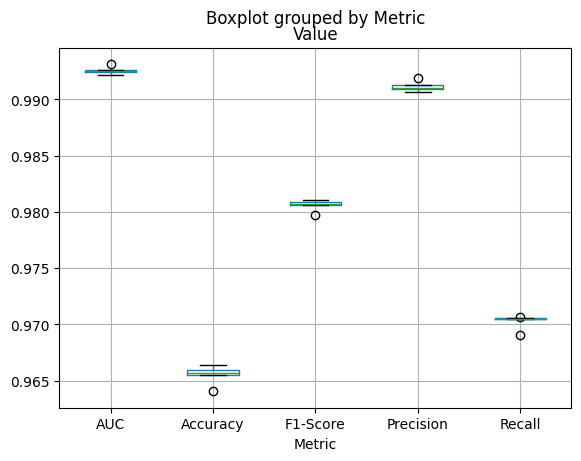

In [ ]:
df_metrics.boxplot(column='Value', by='Metric')

In [ ]:
print("WHITE/NOT WHITE:")
white_summary

WHITE/NOT WHITE:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,-0.023769,0.003067
Equalised Odds,-0.007186,0.004262
False Positive Rate Balance,0.009398,0.009003
Predictive Parity Difference,-0.008217,0.002689
Statistical Parity Difference,-0.061138,0.003165


In [ ]:
print("\nBLACK/NOT BLACK:")
black_summary


BLACK/NOT BLACK:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,-0.008317,0.003513
Equalised Odds,-0.012535,0.004974
False Positive Rate Balance,-0.016754,0.009985
Predictive Parity Difference,-0.013179,0.003923
Statistical Parity Difference,-0.115024,0.007810


In [ ]:
print("\nASIAN/WHITE:")
asianwhite_summary


ASIAN/WHITE:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,-0.031891,0.003844
Equalised Odds,0.010286,0.009164
False Positive Rate Balance,0.052462,0.018972
Predictive Parity Difference,-0.004707,0.002263
Statistical Parity Difference,-0.017813,0.005048


In [ ]:
print("\ASIAN/BLACK:")
asianblack_summary

\ASIAN/BLACK:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,0.019847,0.004598
Equalised Odds,-0.021469,0.009511
False Positive Rate Balance,-0.062785,0.018712
Predictive Parity Difference,-0.008807,0.002810
Statistical Parity Difference,-0.099329,0.009706


In [ ]:

explainer = shap.TreeExplainer(lgb_model, X_train)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

